In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import librosa
import librosa.display

import tensorflow as tf
import keras
from keras import layers

In [2]:
df = pd.read_csv(r'UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Visualize Data

#### Check Data distribution 

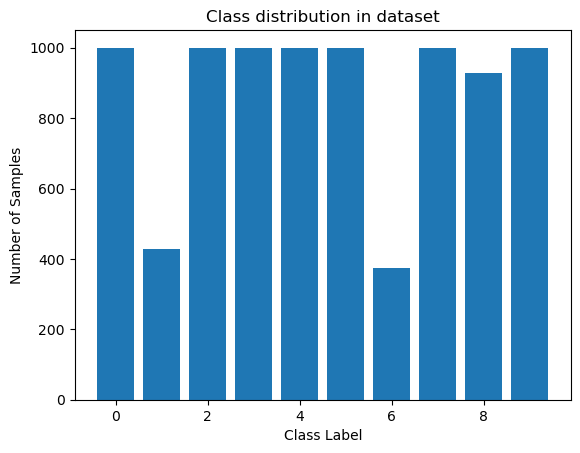

[0 1 2 3 4 5 6 7 8 9] [1000  429 1000 1000 1000 1000  374 1000  929 1000]


In [59]:
unique_labels, counts = np.unique(df.classID, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

#### Pick a sample to display  

In [60]:
# 6192, 4729
sample_num = 4729

# get the filename
filename = df.slice_file_name[sample_num] 
print(filename)

path = '../UrbanSound8K/audio/fold' + str(df.fold[sample_num]) + '/' + str(filename)
signal, sr = librosa.load(path, sr=22050) # sr*T -> 22050*4

189895-3-0-0.wav


#### Waveform

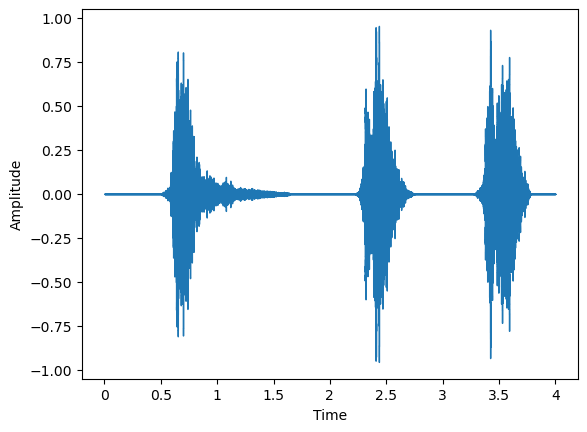

In [61]:
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

#### FFT -> Spectrum

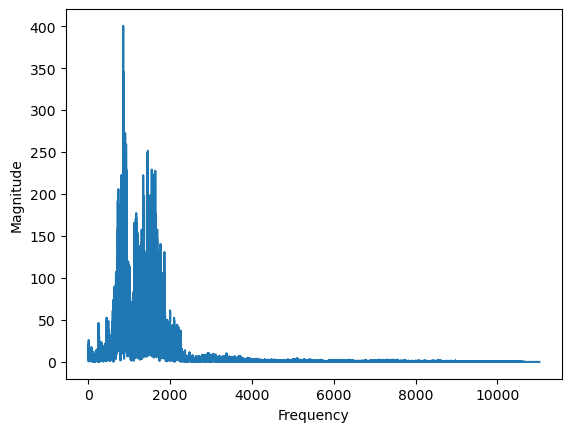

In [62]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

#### STFT -> Spectrogram

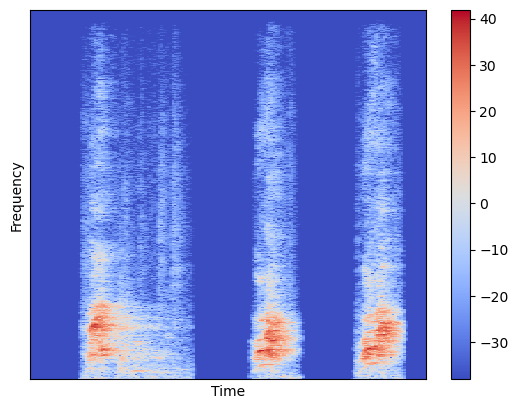

In [63]:
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)

librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

#### MFCCs

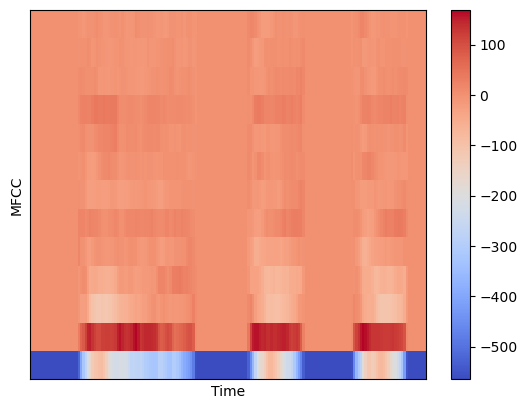

In [64]:
MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

## Data Preprocessing and Feature Extraction

#### Padding Audio Files

In [3]:
def zero_padded_data_nparray(audios_path, duration_secs = 4, sr = 22050, files_limit = -1, verbose = False):

    files = librosa.util.find_files(audios_path)
    data_array = []

    for index, path_file in enumerate(files):
        if files_limit != -1 and index >= files_limit: break
        
        if verbose:
            print(f"At audio {index+1}/{len(files)}")
            
        signal, sr = librosa.load(path_file, sr = sr, mono=True)
        
        # zero padding
        if len(signal) < duration_secs*sr:
            signal = np.concatenate([
                signal,
                np.zeros(shape = (duration_secs*sr - len(signal), ))
            ])
        elif len(signal) > duration_secs*sr:
            signal = signal[:duration_secs*sr]
            

        if len(signal) == duration_secs*sr:
            lst = path_file.split("\\")
            file_name = lst[-1]
            newrow = [file_name, signal]
            data_array.append(newrow)
        else:
            print(file_name)
            print(path_file) 
        
    return data_array

#### Feature extraction -> MFCCs

In [4]:
def get_features(df_in, signals, hop_length = 512, n_fft = 2048, n_mfcc = 13, sr = 22050):
    
    features = [] # list to save features
    labels = [] # list to save labels
    
    for index in range(len(signals)):

        # get the filename        
        filename = signals[index][0]
        if filename:
            
            # find correspondig row in df_in
            row = df_in.loc[df_in["slice_file_name"] == filename]

            if not row.empty:
                # save labels
                label = row.iloc[0,6] 

                mfcc = librosa.feature.mfcc(y = np.array(signals[index][1]), 
                                            sr=sr, 
                                            n_fft = n_fft,  
                                            n_mfcc = n_mfcc,
                                            hop_length = hop_length)
                mfcc = mfcc.T

                features.append(np.array([mfcc]))
                labels.append(label)
                
            else: 
                print(f"No matching row for filename {filename}")
        else:
            print("Empty filename")

    # check is features and labels  have the same lenght
    assert len(features) == len(labels)

    output = np.concatenate(features, axis = 0)
    return(np.array(output), labels)

In [9]:
fold_paths = ["../UrbanSound8K/audio/fold1/", "../UrbanSound8K/audio/fold2/", "../UrbanSound8K/audio/fold3/",
              "../UrbanSound8K/audio/fold4/", "../UrbanSound8K/audio/fold5/", "../UrbanSound8K/audio/fold6/",
              "../UrbanSound8K/audio/fold7/", "../UrbanSound8K/audio/fold8/", "../UrbanSound8K/audio/fold9/",
              "../UrbanSound8K/audio/fold10/"]

features = [10]
labels = [10]

for i in range(len(fold_paths)):
    print(fold_paths[i])

    # Adding ZEro-Padding to audio 
    audio = zero_padded_data_nparray(fold_paths[i])

    # Feature Extraction
    X,y = get_features(df, audio)

    # Data Normalization Min-Max scaling to [-1, 1] 
    X_scaled = (X - np.min(X)) / (np.max(X) - np.min(X))

    # One-Hot Encoding Target feature
    y_encoded = np.zeros((len(y), max(y) +1))
    y_encoded[np.arange(len(y)), y] = 1

    # Saving Features and Labels to 
    features.append(np.array(X_scaled))
    labels.append(y_encoded)

features = features[1:]
labels = labels[1:]

../UrbanSound8K/audio/fold1/
../UrbanSound8K/audio/fold2/
../UrbanSound8K/audio/fold3/
../UrbanSound8K/audio/fold4/
../UrbanSound8K/audio/fold5/
../UrbanSound8K/audio/fold6/
../UrbanSound8K/audio/fold7/
../UrbanSound8K/audio/fold8/
../UrbanSound8K/audio/fold9/
../UrbanSound8K/audio/fold10/


## Building the Recurent Neural Network


#### Build Network topology

In [ ]:
# DEnse kernel_initializer=he_normal()

In [83]:
input_shape = (173, 13) # shape of X_train

model = keras.Sequential()

# 2 LSTM layers
model.add(layers.LSTM(128,  input_shape = input_shape, return_sequences = True, activation='tanh')) 
model.add(layers.LSTM(128, return_sequences = True, activation='tanh'))
model.add(layers.LSTM(128, return_sequences = True, activation='tanh'))

model.add(layers.Dropout(0.3))

model.add(layers.BatchNormalization())

model.add(layers.TimeDistributed(layers.Dense(128, activation = 'tanh', kernel_initializer='random_normal')))
model.add(layers.TimeDistributed(layers.Dense(64, activation='tanh')))

model.add(layers.Dropout(0.3))

model.add(layers.TimeDistributed(layers.Dense(32, activation='tanh')))
model.add(layers.TimeDistributed(layers.Dense(16, activation='tanh')))
model.add(layers.TimeDistributed(layers.Dense(8, activation='tanh')))

model.add(layers.Dropout(0.3))

model.add(layers.BatchNormalization())

# Flatten layer 
model.add(layers.Flatten())

# Output layer
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 173, 128)          72704     
                                                                 
 lstm_42 (LSTM)              (None, 173, 128)          131584    
                                                                 
 dropout_35 (Dropout)        (None, 173, 128)          0         
                                                                 
 batch_normalization_9 (Batc  (None, 173, 128)         512       
 hNormalization)                                                 
                                                                 
 time_distributed_101 (TimeD  (None, 173, 128)         16512     
 istributed)                                                     
                                                                 
 time_distributed_102 (TimeD  (None, 173, 64)        

#### Compile the Model

The **Adam** optimizer manages the learning rate for stochastic gradient descent. The loss function is **categorical_crossentropy**, which is used when the target label is One-Hot-Encoded. 

In [84]:
optimizer1 = keras.optimizers.Adam(learning_rate = 0.001)
optimizer2 = keras.optimizers.SGD(clipvalue = 0.5, learning_rate = 0.005)

model.compile(optimizer = optimizer2, loss = 'categorical_crossentropy', metrics=['accuracy'])

## 10-Fold Cross Validation

In [85]:
metrics = {'accuracy':[], 'loss':[], 'confusion_matrix':[], 'history':[]}

for fold in range(1):
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    # Splitting the data into Test, Validation and Training sets
    for i in range(10):
        if( i != fold):
            X_train += features[i].tolist()
            y_train.extend(labels[i])
           
        else:
            X_test = features[i]
            y_test = labels[i]

    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
        
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = 123)

    # Print sets shapes
    print(f"X_train Shape: {X_train.shape}")
    print(f"X_test Shape: {X_test.shape}")
    print(f"X_val Shape: {X_val.shape}")

    # Train model
    rnn = model.fit(X_train, y_train, epochs = 50, batch_size = 100, validation_data = (X_val, y_val), shuffle = False)

    y_pred = model.predict(X_test)

    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)
    TestLoss, Testacc = model.evaluate(X_test, y_test)

    metrics['accuracy'].append(Testacc)
    metrics['loss'].append(TestLoss)
    metrics['confusion_matrix'].append(confusion_matrix(y_test_reshape, y_pred_reshape))
    metrics['history'].append(rnn.history)

    

X_train Shape: (7859, 173, 13)
X_test Shape: (436, 173, 13)
X_val Shape: (437, 173, 13)
Epoch 1/50
79/79 [==============================] - 62s 665ms/step - loss: 2.8738 - accuracy: 0.1185 - val_loss: 2.2497 - val_accuracy: 0.1167
Epoch 2/50
79/79 [==============================] - 47s 590ms/step - loss: 2.5163 - accuracy: 0.1620 - val_loss: 2.0647 - val_accuracy: 0.2311
Epoch 3/50
79/79 [==============================] - 49s 616ms/step - loss: 2.3605 - accuracy: 0.1803 - val_loss: 1.9979 - val_accuracy: 0.2082
Epoch 4/50
79/79 [==============================] - 50s 632ms/step - loss: 2.2831 - accuracy: 0.1953 - val_loss: 2.1828 - val_accuracy: 0.1281
Epoch 5/50
79/79 [==============================] - 51s 644ms/step - loss: 2.2014 - accuracy: 0.2120 - val_loss: 2.1789 - val_accuracy: 0.1968
Epoch 6/50
79/79 [==============================] - 53s 667ms/step - loss: 2.1368 - accuracy: 0.2295 - val_loss: 2.6701 - val_accuracy: 0.1350
Epoch 7/50
79/79 [==============================] - 53

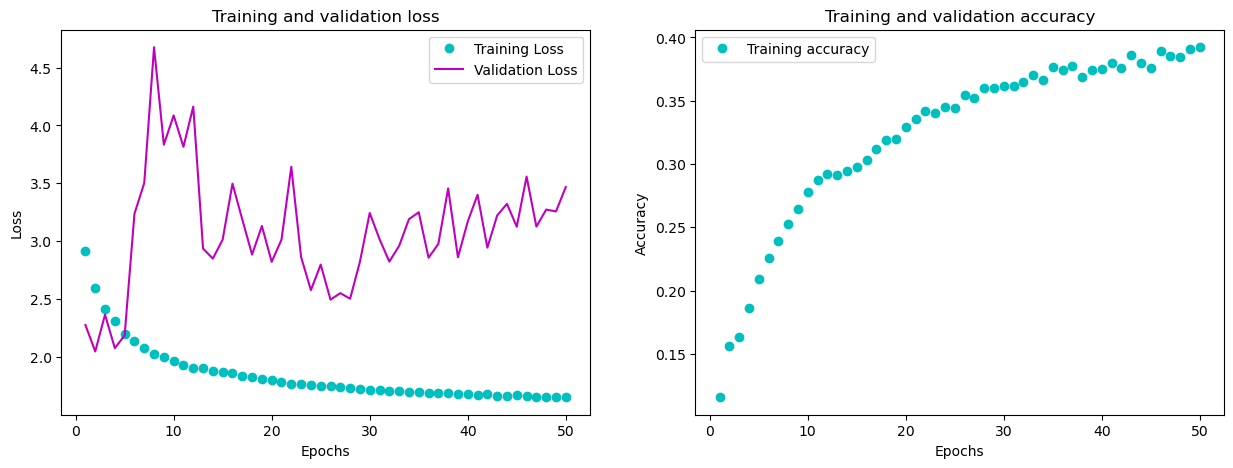

In [82]:
history_dict = rnn.history

loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']

epochs = range(1,51)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [80]:
metrics['accuracy']
metrics['confusion_matrix']
metrics['loss']
history_dict = metrics['history'].history


loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']

epochs = range(1,51)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

AttributeError: 'list' object has no attribute 'history'